# UMAP Visualization MoA - Well Level

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import umap
from tqdm.notebook import tqdm

import util_unsupervised as util_u

/home/mhuebsch/.conda/envs/ms2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_dir = "~/siads696/data"
image_dir = "/home/mhuebsch/SIADS696_Milestone2/images"

## Load Embedding Vector File

In [4]:
df_embed_vec = util_u.load_embed_file(os.path.join(data_dir, "tl_features.csv"))
print(f"Shape embedding vector dataframe: {df_embed_vec.shape}")

Shape embedding vector dataframe: (13200, 3088)


In [5]:
df_embed_vec.head()

,Metadata_ID,Metadata_TableNumber,Metadata_ImageNumber,Metadata_Plate_DAPI,Metadata_Well_DAPI,Metadata_Replicate,Metadata_Compound,Metadata_Concentration,Metadata_SMILES,Metadata_MoA,...,Z1014_Actin,Z1015_Actin,Z1016_Actin,Z1017_Actin,Z1018_Actin,Z1019_Actin,Z1020_Actin,Z1021_Actin,Z1022_Actin,Z1023_Actin
0,4_233,4,233,Week4_27481,G10,1,5-fluorouracil,0.003,FC1=CNC(=O)NC1=O,NaN,...,0.375635,0.188088,-0.250119,-0.366313,-0.311198,1.381419,-0.321486,1.215452,-0.089709,-0.413298
1,4_234,4,234,Week4_27481,G10,1,5-fluorouracil,0.003,FC1=CNC(=O)NC1=O,NaN,...,0.002416,0.251005,-0.229220,0.139000,0.023661,1.703081,-0.629341,2.002971,0.416103,-0.491764
2,4_235,4,235,Week4_27481,G10,1,5-fluorouracil,0.003,FC1=CNC(=O)NC1=O,NaN,...,0.542001,0.291677,-0.292990,-0.361006,-0.398080,1.291885,-0.288020,0.750829,-0.016331,-0.539989
3,4_236,4,236,Week4_27481,G10,1,5-fluorouracil,0.003,FC1=CNC(=O)NC1=O,NaN,...,0.201174,0.477845,-0.373518,-0.289697,-0.150430,0.875186,-0.315154,1.510594,0.013336,-0.460936
4,4_473,4,473,Week4_27521,G10,2,5-fluorouracil,0.003,FC1=CNC(=O)NC1=O,NaN,...,0.185048,0.381037,-0.187140,0.177585,-0.086358,1.435541,-0.425821,0.931412,0.423981,-0.502664


## Do Batch Correction  

### Apply PyCombat

In [6]:
embed_vec_combat = util_u.apply_combat(df_embed_vec, batch_col="Metadata_Plate_DAPI", data_col_pref="Z")
print(f"Shape embedding vector dataframe combat correted: {embed_vec_combat.shape}")

[INFO] Found 55 batches
[INFO] Adjusting for 0 covariate(s) or covariate level(s)
[INFO] Standardizing Data across genes.
[INFO] Fitting L/S model and finding priors.
[INFO] Finding parametric adjustments.
[INFO] Adjusting the Data


Shape embedding vector dataframe combat correted: (13200, 3088)


In [7]:
# embed_vec_combat.head()

### Apply PCA with whitening

In [8]:
embed_vec_comb_pca = util_u.apply_pcawhite(embed_vec_combat, n_components=256, data_col_pref="Z")
print(f"Shape embedding vector dataframe combat+pca correted: {embed_vec_comb_pca.shape}")

Shape embedding vector dataframe combat+pca correted: (13200, 272)


In [9]:
# embed_vec_comb_pca.head()

## Group Columns and MoA

In [10]:
group_cols = ["Metadata_Plate_DAPI", "Metadata_Well_DAPI", "Metadata_Compound", "Metadata_Concentration"]
df_moa = df_embed_vec.groupby(["Metadata_Compound"])["Metadata_MoA"].first().reset_index()

## Use Aggregation: Mean

In [11]:
df_well_comb_pca_mean = util_u.collaps_well(embed_vec_comb_pca, group_cols=group_cols, data_col_pref="PC", method="mean")
print(f"Shape well level dataframe combat+pca correted: {df_well_comb_pca_mean.shape}")

df_well_comb_pca_mean = util_u.add_moa(df_well_comb_pca_mean, moa_df=df_moa, cmpd_col="Metadata_Compound")
print(f"Shape well level dataframe combat+pca correted: {df_well_comb_pca_mean.shape}")

Shape well level dataframe combat+pca correted: (3300, 260)
Shape well level dataframe combat+pca correted: (3300, 261)


In [12]:
# df_well_comb_pca_mean.head()

## Use Aggregation: Median

In [13]:
df_well_comb_pca_median = util_u.collaps_well(embed_vec_comb_pca, group_cols=group_cols, data_col_pref="PC", method="median")
print(f"Shape well level dataframe combat+pca correted: {df_well_comb_pca_median.shape}")

df_well_comb_pca_median = util_u.add_moa(df_well_comb_pca_median, moa_df=df_moa, cmpd_col="Metadata_Compound")
print(f"Shape well level dataframe combat+pca correted: {df_well_comb_pca_median.shape}")

Shape well level dataframe combat+pca correted: (3300, 260)
Shape well level dataframe combat+pca correted: (3300, 261)


## Apply UMAP

### UMAP on Mean

In [14]:
data_cols = [c for c in df_well_comb_pca_mean.columns if c.startswith("PC")]
df_nondmso = df_well_comb_pca_mean[df_well_comb_pca_mean["Metadata_Compound"] != "DMSO"].reset_index()
moa_list = df_nondmso["Metadata_MoA"].unique().tolist()
data = df_nondmso[data_cols]

umap_mean = umap.UMAP(min_dist=0.8, n_neighbors=50, metric="cosine")
embed_well_comb_pca_mean = umap_mean.fit_transform(data)
print(f"UMAP embeddings shape: {embed_well_comb_pca_mean.shape}")

UMAP embeddings shape: (2970, 2)


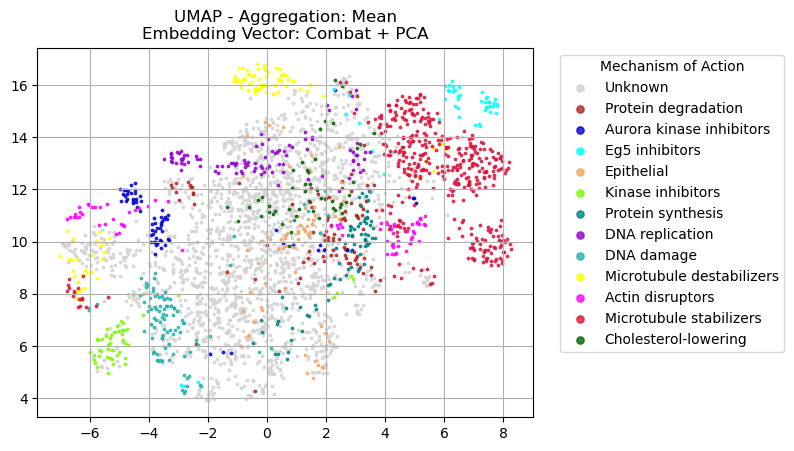

In [15]:
fig, ax = plt.subplots()
for moa in moa_list:
    idx = df_nondmso[df_nondmso["Metadata_MoA"] == moa].index.values.tolist()
    ax.scatter(embed_well_comb_pca_mean[idx, 0], embed_well_comb_pca_mean[idx, 1], s=3, c=util_u.color_map[moa], alpha=0.8, label=moa)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", markerscale=3, title="Mechanism of Action")
plt.title("UMAP - Aggregation: Mean\nEmbedding Vector: Combat + PCA")
plt.savefig(os.path.join(image_dir, "umap_mean.png"), bbox_inches="tight")
plt.show()

### UMAP on Median

In [16]:
data_cols = [c for c in df_well_comb_pca_median.columns if c.startswith("PC")]
df_nondmso = df_well_comb_pca_median[df_well_comb_pca_median["Metadata_Compound"] != "DMSO"].reset_index()
moa_list = df_nondmso["Metadata_MoA"].unique().tolist()
data = df_nondmso[data_cols]

umap_median = umap.UMAP(min_dist=0.8, n_neighbors=50, metric="cosine")
embed_well_comb_pca_median = umap_median.fit_transform(data)
print(f"UMAP embeddings shape: {embed_well_comb_pca_median.shape}")

UMAP embeddings shape: (2970, 2)


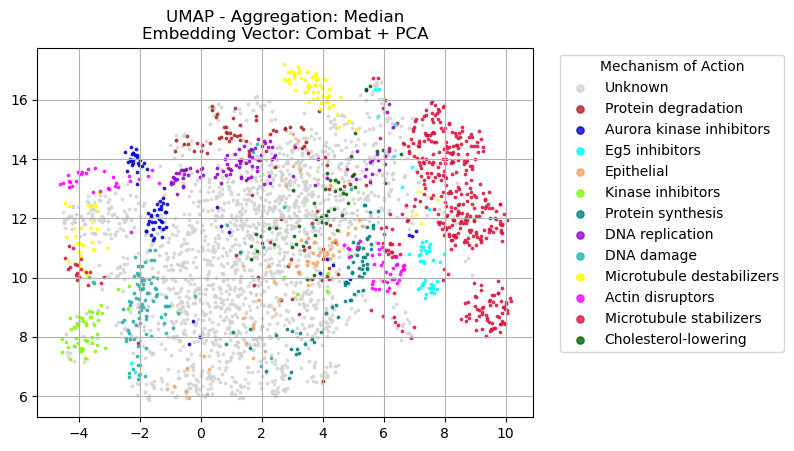

In [17]:
fig, ax = plt.subplots()
for moa in moa_list:
    idx = df_nondmso[df_nondmso["Metadata_MoA"] == moa].index.values.tolist()
    ax.scatter(embed_well_comb_pca_median[idx, 0], embed_well_comb_pca_median[idx, 1], s=3, c=util_u.color_map[moa], alpha=0.8, label=moa)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", markerscale=3, title="Mechanism of Action")
plt.title("UMAP - Aggregation: Median\nEmbedding Vector: Combat + PCA")
plt.savefig(os.path.join(image_dir, "umap_median.png"), bbox_inches="tight")
plt.show()

### UMAP - Microtubule Stabilizers

In [18]:
df_micro_tub = df_well_comb_pca_mean[df_well_comb_pca_mean["Metadata_MoA"] == "Microtubule stabilizers"].reset_index()
micro_tub_compounds = df_micro_tub["Metadata_Compound"].unique().tolist()
micro_tub_data = df_micro_tub[data_cols]

In [19]:
umap_mt = umap.UMAP(min_dist=0.5, n_neighbors=6, metric="cosine")
embed_well_mt = umap_mt.fit_transform(micro_tub_data)
print(f"UMAP embeddings shape: {embed_well_mt.shape}")

UMAP embeddings shape: (402, 2)


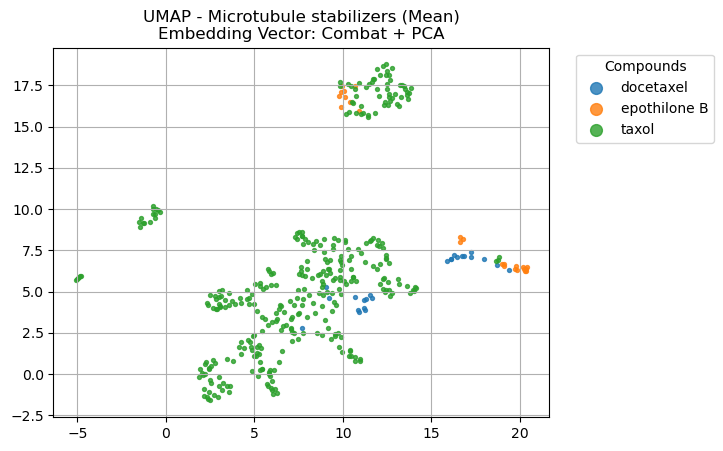

In [20]:
fig, ax = plt.subplots()
for i, cmpd in enumerate(micro_tub_compounds):
    idx = df_micro_tub[df_micro_tub["Metadata_Compound"] == cmpd].index.values.tolist()
    ax.scatter(embed_well_mt[idx, 0], embed_well_mt[idx, 1], s=8, alpha=0.8, label=cmpd)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", markerscale=3, title="Compounds")
plt.title("UMAP - Microtubule stabilizers (Mean)\nEmbedding Vector: Combat + PCA")
plt.savefig(os.path.join(image_dir, "umap_micro_tub_mean.png"), bbox_inches="tight")
plt.show()

### UMAP - Aurora Kinase Inhibitors

In [21]:
df_ak_inhib = df_well_comb_pca_mean[df_well_comb_pca_mean["Metadata_MoA"] == "Aurora kinase inhibitors"].reset_index()
ak_inhib_compounds = df_ak_inhib["Metadata_Compound"].unique().tolist()
ak_inhib_data = df_ak_inhib[data_cols]

In [22]:
umap_aki = umap.UMAP(min_dist=0.2, n_neighbors=4, metric="cosine")
embed_well_aki = umap_aki.fit_transform(ak_inhib_data)
print(f"UMAP embeddings shape: {embed_well_aki.shape}")

UMAP embeddings shape: (72, 2)


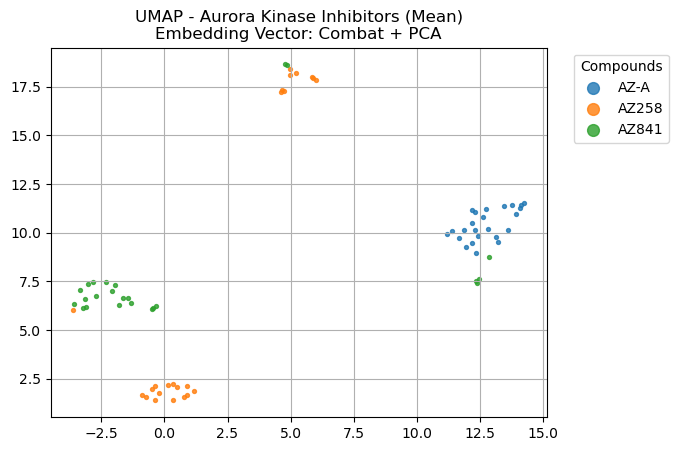

In [23]:
fig, ax = plt.subplots()
for i, cmpd in enumerate(ak_inhib_compounds):
    idx = df_ak_inhib[df_ak_inhib["Metadata_Compound"] == cmpd].index.values.tolist()
    ax.scatter(embed_well_aki[idx, 0], embed_well_aki[idx, 1], s=8, alpha=0.8, label=cmpd)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", markerscale=3, title="Compounds")
plt.title("UMAP - Aurora Kinase Inhibitors (Mean)\nEmbedding Vector: Combat + PCA")
plt.savefig(os.path.join(image_dir, "umap_ak_inhib_mean.png"), bbox_inches="tight")
plt.show()